In [29]:
# Using Gold prices as a predictor for Bitcoin prices with a two week window uwing LSTM RNN model

In [30]:
## Data Preparation
# 1. Rolling 10 day window (ten trading days)
# 2. 70% training data 30% testing data
# 3. Use MinMaxScaler to X and y values

In [31]:
# Imports

import yfinance as yf
import numpy as np
import pandas as pd
import hvplot.pandas

In [32]:
# Setting random seed for testing - will comment out for final product

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [33]:
# Load price data for gold using yfinance

index_df = yf.download("^VIX", start='2021-01-01', end='2021-06-02')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^VIX'})
#index_df = index_df['^VIX'].pct_change()
#index_df = index_df.dropna()
index_df.head()

[*********************100%***********************]  1 of 1 completed


,^VIX
Date,
2021-01-04,26.969999
2021-01-05,25.340000
2021-01-06,25.070000
2021-01-07,22.370001
2021-01-08,21.559999


In [34]:
# Load price data for Bitcoin using yfinance
stock_df = yf.download("^RUT", start='2021-01-01', end='2021-06-02')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
#stock_df = stock_df['^RUT'].pct_change()
#stock_df = stock_df.dropna()
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,^RUT
Date,
2021-01-04,1945.910034
2021-01-05,1979.109985
2021-01-06,2057.919922
2021-01-07,2096.889893
2021-01-08,2091.659912


In [35]:
# Concatenate into single df

df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,^VIX,^RUT
Date,,
2021-01-04,26.969999,1945.910034
2021-01-05,25.340000,1979.109985
2021-01-06,25.070000,2057.919922
2021-01-07,22.370001,2096.889893
2021-01-08,21.559999,2091.659912
2021-01-11,24.080000,2091.010010
2021-01-12,23.330000,2127.959961
2021-01-13,22.209999,2111.969971
2021-01-14,23.250000,2155.350098


In [36]:
# Below function takes column number for the features (X) and target (y)
# It accumulates the data with a rolling window of X(t-n) to predict Xt
# Finally, it returns a numpy array of X and y

def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    print(len(df) - window - 1)
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [37]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'index' column
# Column index 1 is the 'stock' column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

92


In [38]:
# 70% of data will be for training and 30% for testing

from sklearn.model_selection import train_test_split
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [39]:
# Scaling data between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [40]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
## Building/training LSTM RNN

In [42]:
# Imports from tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [43]:
# LSTM Model
# How many layers are we doing? Check before doing return sequences. Set to True if adding more LSTM layers but not for final layer
# Input shape: number of time steps and number of indicators
# Dropouts to prevent overfitting
# Define the LSTM RNN model

model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer

model.add(Dense(1))

In [44]:
# Compile the model
# What is Adam?

model.compile(optimizer="adam", loss="mean_squared_error")

In [45]:
# Summarize the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 5)             140       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [46]:
# Train the model
# Use at least 10 epochs - maybe more
# Experiement with the batch size, stick to smaller or?
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
64/64 [==============================] - 11s 13ms/step - loss: 0.1870
Epoch 2/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0682
Epoch 3/10
64/64 [==============================] - 1s 13ms/step - loss: 0.1000
Epoch 4/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0900
Epoch 5/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0904
Epoch 6/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0846
Epoch 7/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0904
Epoch 8/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0714
Epoch 9/10
64/64 [==============================] - 1s 13ms/step - loss: 0.1016
Epoch 10/10
64/64 [==============================] - 1s 13ms/step - loss: 0.0782


In [47]:
## Model Performance

In [48]:
# Evaluate the model

model.evaluate(X_test, y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.0221


0.02206423319876194

In [49]:
# Predictions

predicted = model.predict(X_test)

In [50]:
# Recover the unscaled prices

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [51]:
# Create df of predicted and real prices

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2021-04-22,2239.629883,2225.279785
2021-04-23,2232.610107,2225.072754
2021-04-26,2271.860107,2224.987793
2021-04-27,2298.010010,2225.140137
2021-04-28,2301.270020,2225.309326


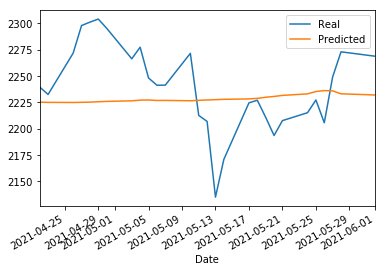

In [52]:
# Real vs predicted line plot to check fit

stocks.plot()

In [53]:
index_df = yf.download("^VIX", start='2021-01-01', end='2021-06-02')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'VIX^'})
index_df.head()

[*********************100%***********************]  1 of 1 completed


,VIX^
Date,
2021-01-04,26.969999
2021-01-05,25.340000
2021-01-06,25.070000
2021-01-07,22.370001
2021-01-08,21.559999


In [54]:
stock_df = yf.download("^RUT", start='2021-01-01', end='2021-06-02')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,^RUT
Date,
2021-01-04,1945.910034
2021-01-05,1979.109985
2021-01-06,2057.919922
2021-01-07,2096.889893
2021-01-08,2091.659912


In [55]:
df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,VIX^,^RUT
Date,,
2021-01-04,26.969999,1945.910034
2021-01-05,25.340000,1979.109985
2021-01-06,25.070000,2057.919922
2021-01-07,22.370001,2096.889893
2021-01-08,21.559999,2091.659912
2021-01-11,24.080000,2091.010010
2021-01-12,23.330000,2127.959961
2021-01-13,22.209999,2111.969971
2021-01-14,23.250000,2155.350098


In [56]:
correlation = df.corr()
correlation

,VIX^,^RUT
VIX^,1.000000,-0.584278
^RUT,-0.584278,1.000000
